# Garbage Image Classification 
## Import Libraries

In [2]:
import os, shutil, random, pathlib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, callbacks
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetV2L
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import kagglehub
from PIL import Image
import zipfile
from IPython.display import Image as IPyImage, display

## Load and Split Dataset (70, 15, 15)

In [3]:
path = kagglehub.dataset_download("sumn2u/garbage-classification-v2")
print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/garbage-classification-v2


In [4]:
dataset_dir = '/kaggle/input/garbage-classification-v2/garbage-dataset' 
classes = os.listdir(dataset_dir)
print("Classes found:", classes),

Classes found: ['metal', 'glass', 'biological', 'paper', 'battery', 'trash', 'cardboard', 'shoes', 'clothes', 'plastic']


(None,)

In [5]:
image_paths = []
labels = []
for label, class_name in enumerate(classes):
    class_folder = os.path.join(dataset_dir, class_name)
    if os.path.isdir(class_folder): 
        for image_file in os.listdir(class_folder):
            image_paths.append(os.path.join(class_folder, image_file))
            labels.append(label)

In [6]:
X_train, X_temp, y_train, y_temp = train_test_split(image_paths, labels, test_size=0.30, stratify=labels, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, stratify=y_temp, random_state=42)

print(f"Training set size: {len(X_train)}")
print(f"Validation set size: {len(X_val)}")
print(f"Test set size: {len(X_test)}")

Training set size: 13833
Validation set size: 2964
Test set size: 2965


In [7]:
def move_files(image_paths, labels, split_dir):
    for img_path, label in zip(image_paths, labels):
        label_folder = os.path.join(split_dir, str(label))  
        if not os.path.exists(label_folder):
            os.makedirs(label_folder)
        shutil.copy(img_path, os.path.join(label_folder, os.path.basename(img_path)))

train_dir = '/kaggle/working/train'
val_dir = '/kaggle/working/val'
test_dir = '/kaggle/working/test'
move_files(X_train, y_train, train_dir)
move_files(X_val, y_val, val_dir)
move_files(X_test, y_test, test_dir)

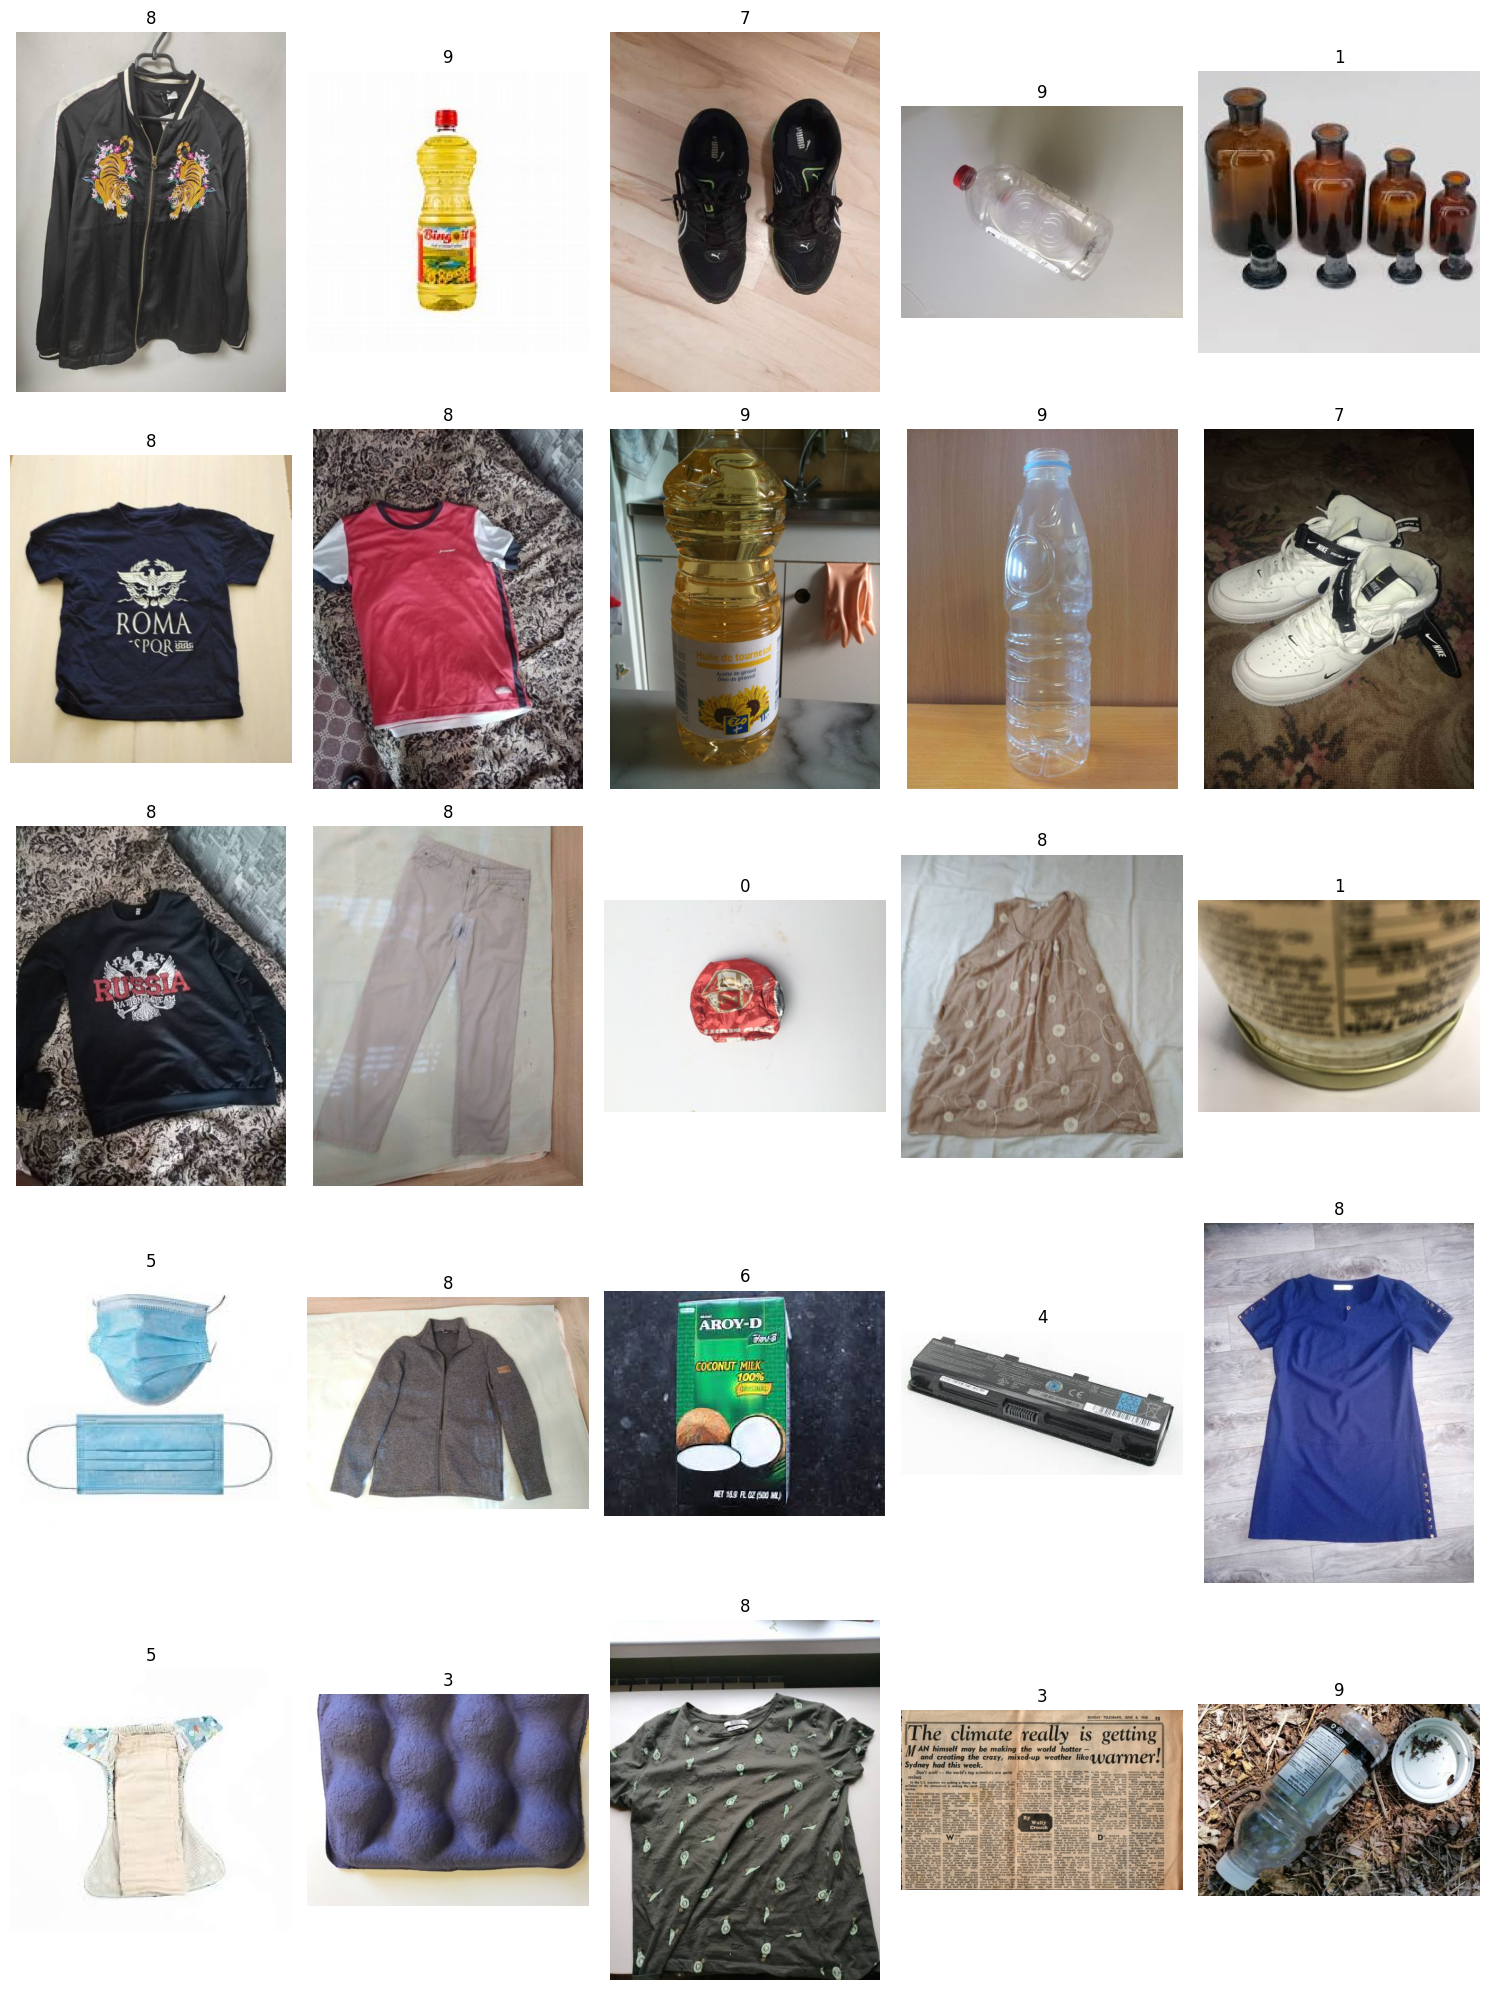

In [16]:
original_path = '/kaggle/working/train'
class_folders = os.listdir(original_path)

all_image_paths = []
all_labels = []

for label in class_folders:
    folder_path = os.path.join(original_path, label)
    if os.path.isdir(folder_path):
        for fname in os.listdir(folder_path):
            if fname.lower().endswith(('jpg', 'jpeg', 'png')):
                all_image_paths.append(os.path.join(folder_path, fname))
                all_labels.append(label)

idxs = random.sample(range(len(all_image_paths)), 25)

plt.figure(figsize=(15, 20))
for i, idx in enumerate(idxs):
    img = Image.open(all_image_paths[idx])
    ax = plt.subplot(5, 5, i + 1)
    plt.imshow(img)
    plt.title(all_labels[idx])
    plt.axis("off")
plt.tight_layout()
plt.show()

## Preprocess Images

In [9]:
IMG_SIZE = (384, 384)
BATCH_SIZE = 32

In [10]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    brightness_range=[0.8, 1.2],
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [11]:
valid_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [12]:
train_dataset = train_datagen.flow_from_directory(train_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical')
valid_dataset = valid_datagen.flow_from_directory(val_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical')
test_dataset = test_datagen.flow_from_directory(test_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical', shuffle=False)

Found 13833 images belonging to 10 classes.
Found 2964 images belonging to 10 classes.
Found 2965 images belonging to 10 classes.


## Build Model 

In [17]:
base_model = EfficientNetV2L(include_top=False, weights='imagenet', input_shape=(384, 384, 3))
base_model.trainable = True
for layer in base_model.layers[:-30]:
    layer.trainable = False

model = Sequential([
    base_model,
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2),
    Conv2D(256, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    GlobalAveragePooling2D(),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(train_dataset.num_classes, activation='softmax')
])

In [18]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetv2-l (Functional)        │ (None, 12, 12, 1280)        │     117,746,848 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 12, 12, 128)         │       1,474,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 12, 12, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 6, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 6, 6, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 6, 6, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 256)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 10)                  │           2,570 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 119,586,602 (456.19 MB)

 Trainable params: 12,593,866 (48.04 MB)

 Non-trainable params: 106,992,736 (408.14 MB)

In [19]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [20]:
history = model.fit(train_dataset, validation_data=valid_dataset, epochs=30, callbacks=[
    EarlyStopping(patience=5, restore_best_weights=True),
    ModelCheckpoint("best.keras", save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)
])

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1745617114.456230     416 service.cc:148] XLA service 0x7b9f180038d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745617114.456288     416 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1745617122.170055     416 cuda_dnn.cc:529] Loaded cuDNN version 90300
E0000 00:00:1745617141.113999     416 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1745617141.461580     416 gpu_timer.cc:

391/433 ━━━━━━━━━━━━━━━━━━━━ 47s 1s/step - accuracy: 0.8046 - loss: 0.6125

E0000 00:00:1745617637.354898     418 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1745617637.688179     418 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


433/433 ━━━━━━━━━━━━━━━━━━━━ 759s 1s/step - accuracy: 0.8115 - loss: 0.5931 - val_accuracy: 0.9410 - val_loss: 0.1951 - learning_rate: 0.0010
Epoch 2/30
433/433 ━━━━━━━━━━━━━━━━━━━━ 543s 1s/step - accuracy: 0.9270 - loss: 0.2398 - val_accuracy: 0.9545 - val_loss: 0.1573 - learning_rate: 0.0010
Epoch 3/30
433/433 ━━━━━━━━━━━━━━━━━━━━ 517s 1s/step - accuracy: 0.9418 - loss: 0.1908 - val_accuracy: 0.9632 - val_loss: 0.1331 - learning_rate: 0.0010
Epoch 4/30
433/433 ━━━━━━━━━━━━━━━━━━━━ 521s 1s/step - accuracy: 0.9532 - loss: 0.1590 - val_accuracy: 0.9656 - val_loss: 0.1370 - learning_rate: 0.0010
Epoch 5/30
433/433 ━━━━━━━━━━━━━━━━━━━━ 520s 1s/step - accuracy: 0.9577 - loss: 0.1425 - val_accuracy: 0.9683 - val_loss: 0.1245 - learning_rate: 0.0010
Epoch 6/30
433/433 ━━━━━━━━━━━━━━━━━━━━ 527s 1s/step - accuracy: 0.9604 - loss: 0.1283 - val_accuracy: 0.9659 - val_loss: 0.1202 - learning_rate: 0.0010
Epoch 7/30
433/433 ━━━━━━━━━━━━━━━━━━━━ 527s 1s/step - accuracy: 0.9694 - loss: 0.1015 - val_

## Evaluate Model Performance

In [21]:
loss, accuracy = model.evaluate(test_dataset)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

93/93 ━━━━━━━━━━━━━━━━━━━━ 49s 531ms/step - accuracy: 0.9707 - loss: 0.1202
Test Accuracy: 97.13%


93/93 ━━━━━━━━━━━━━━━━━━━━ 78s 622ms/step


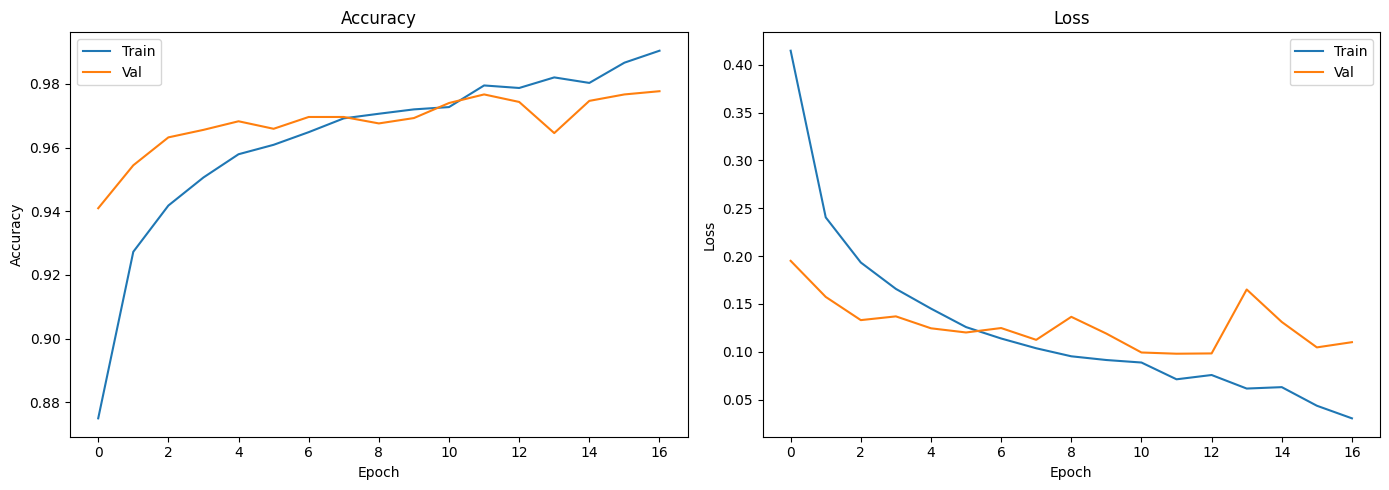

In [22]:
x_test = test_dataset
pred1 = model.predict(x_test)
final_pred = pred1
final_labels = np.argmax(final_pred, axis=1)
true_labels = test_dataset.classes

plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Val')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Val')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

## Save the Model

In [23]:
model.export('saved_model')
print("Model disimpan dalam format TensorFlow SavedModel.")

Saved artifact at 'saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 384, 384, 3), dtype=tf.float32, name='keras_tensor_2068')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  135926782309584: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135923938597328: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135923938596944: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135926782308624: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135923938598096: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135923938598288: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135923938599248: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135923938600016: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135923938591376: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135923938598672: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1359239386002

In [24]:
if not os.path.exists("tflite"):
    os.makedirs("tflite")
converter = tf.lite.TFLiteConverter.from_saved_model("saved_model")
tflite_model = converter.convert()
with open("model.tflite", "wb") as f:
    f.write(tflite_model)

W0000 00:00:1745626495.371490     343 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1745626495.371529     343 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
I0000 00:00:1745626496.169592     343 mlir_graph_optimization_pass.cc:401] MLIR V1 optimization pass is not enabled


In [38]:
labels = ['metal', 'glass', 'biological', 'paper', 'battery', 'trash', 'cardboard', 'shoes', 'clothes', 'plastic']
os.makedirs("tflite", exist_ok=True)
with open("tflite/label.txt", "w") as f:
    for label in labels:
        f.write(label + "\n")

In [32]:
model.save("model_complete.h5")

In [33]:
import tensorflowjs as tfjs
if not os.path.exists("tfjs_model"):
    os.makedirs("tfjs_model")
tfjs.converters.save_keras_model(model, "tfjs_model")
print("Model berhasil disimpan dalam format TensorFlow.js di tfjs_model.")

failed to lookup keras version from the file,
    this is likely a weight only file
Model berhasil disimpan dalam format TensorFlow.js di tfjs_model.


In [34]:
os.makedirs("submission/tfjs_model", exist_ok=True)
os.makedirs("submission/tflite", exist_ok=True)
os.makedirs("submission/saved_model", exist_ok=True)

shutil.copy("model.tflite", "submission/tflite/model.tflite")
shutil.copytree("saved_model/variables", "submission/saved_model/variables", dirs_exist_ok=True)
shutil.copy("saved_model/saved_model.pb", "submission/saved_model/saved_model.pb")
shutil.copytree("tfjs_model", "submission/tfjs_model", dirs_exist_ok=True)

shutil.make_archive("/kaggle/working/submission", 'zip', "submission")
print("Model telah disimpan dan dikompresi dalam format SavedModel, TFLite, dan TensorFlow.js.")

Model telah disimpan dan dikompresi dalam format SavedModel, TFLite, dan TensorFlow.js.


## Inference on New Images ( TF Lite)

In [39]:
with open("tflite/label.txt", "r") as f:
    labels = [line.strip() for line in f.readlines()]

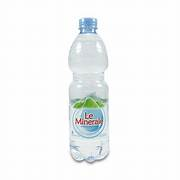

Predicted Index: 9
Predicted Label: plastic


In [41]:
def preprocess_image(image_path, target_size=(384, 384)):
    img = Image.open(image_path).convert('RGB')
    img = img.resize(target_size)
    img = np.array(img, dtype=np.float32)
    img = preprocess_input(img)  
    img = np.expand_dims(img, axis=0)
    return img

image_path = "/kaggle/input/cobacoba/botol.jpg"
input_data = preprocess_image(image_path)

interpreter = tf.lite.Interpreter(model_path="model.tflite")
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

interpreter.set_tensor(input_details[0]['index'], input_data)
interpreter.invoke()
output_data = interpreter.get_tensor(output_details[0]['index'])

predicted_index = np.argmax(output_data)
with open("tflite/label.txt", "r") as f:
    labels = [line.strip() for line in f.readlines()]
predicted_label = labels[predicted_index]

display(IPyImage(image_path))
print(f"Predicted Index: {predicted_index}")
print(f"Predicted Label: {predicted_label}")

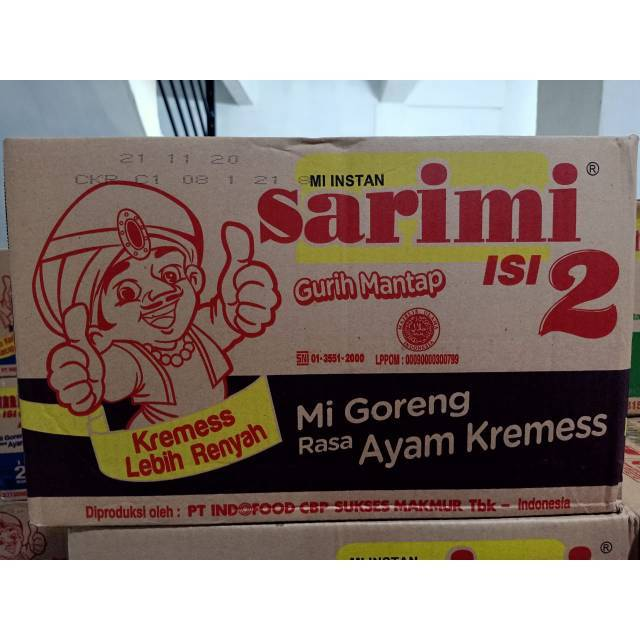

Predicted Index: 6
Predicted Label: cardboard


In [42]:
def preprocess_image(image_path, target_size=(384, 384)):
    img = Image.open(image_path).convert('RGB')
    img = img.resize(target_size)
    img = np.array(img, dtype=np.float32)
    img = preprocess_input(img)  
    img = np.expand_dims(img, axis=0)
    return img

image_path = "/kaggle/input/cobacoba/kardus.jpg"
input_data = preprocess_image(image_path)

interpreter = tf.lite.Interpreter(model_path="model.tflite")
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

interpreter.set_tensor(input_details[0]['index'], input_data)
interpreter.invoke()
output_data = interpreter.get_tensor(output_details[0]['index'])

predicted_index = np.argmax(output_data)
with open("tflite/label.txt", "r") as f:
    labels = [line.strip() for line in f.readlines()]
predicted_label = labels[predicted_index]

display(IPyImage(image_path))
print(f"Predicted Index: {predicted_index}")
print(f"Predicted Label: {predicted_label}")

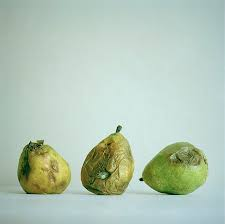

Predicted Index: 2
Predicted Label: biological


In [43]:
def preprocess_image(image_path, target_size=(384, 384)):
    img = Image.open(image_path).convert('RGB')
    img = img.resize(target_size)
    img = np.array(img, dtype=np.float32)
    img = preprocess_input(img)  
    img = np.expand_dims(img, axis=0)
    return img

image_path = "/kaggle/input/cobacoba/buah_busuk.jpg"
input_data = preprocess_image(image_path)

interpreter = tf.lite.Interpreter(model_path="model.tflite")
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

interpreter.set_tensor(input_details[0]['index'], input_data)
interpreter.invoke()
output_data = interpreter.get_tensor(output_details[0]['index'])

predicted_index = np.argmax(output_data)
with open("tflite/label.txt", "r") as f:
    labels = [line.strip() for line in f.readlines()]
predicted_label = labels[predicted_index]

display(IPyImage(image_path))
print(f"Predicted Index: {predicted_index}")
print(f"Predicted Label: {predicted_label}")